# Deep Q-Learning Implementation for CartPole

This implementation applies Deep Q-Learning to the CartPole problem, which is a classic control task modeled as a Markov Decision Process (MDP) with:
- **State space**: Cart position, cart velocity, pole angle, and pole angular velocity
- **Action space**: Push cart left (0) or right (1)
- **Reward**: +1 for each timestep the pole remains upright

The code below sets up:
1. Required libraries and environment parameters
2. Training hyperparameters including discount factor (γ) for future rewards
3. Neural network architecture for Q-function approximation
4. Exploration strategy parameters (ε-greedy approach)
5. Target network update frequency to stabilize training

Key hyperparameters follow DQN best practices, including experience replay (MEMORY_SIZE) and target network updates (UPDATE_TARGET_EVERY) to handle the inherent instabilities of TD-learning with neural networks.

In [1]:
pip install gymnasium numpy tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt

# Environment setup
ENV_NAME = "CartPole-v1"
SEED = 42

# Training parameters
EPISODES = 1000
MAX_STEPS_PER_EPISODE = 500
BATCH_SIZE = 128
MEMORY_SIZE = 200000
GAMMA = 0.99

# Neural Network parameters
LEARNING_RATE = 0.0005
HIDDEN_UNITS = [256, 128]

# Exploration parameters
EPSILON_MAX = 1.0
EPSILON_MIN = 0.2
EPSILON_DECAY = 0.998

# Target network update
UPDATE_TARGET_EVERY = 5

2024-12-30 16:04:36.121698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experience Replay Buffer

In Deep Q-Learning, experience replay is a crucial component that helps stabilize training by breaking the correlation between consecutive samples. This is implemented through a ReplayBuffer class that:

- Stores transitions (state, action, reward, next_state, done) in a fixed-size circular buffer
- Randomly samples batches of experiences for training, following DQN's off-policy learning approach
- Uses Python's deque data structure for efficient memory management
- Returns transitions in a format suitable for neural network training

This mechanism allows the agent to learn from past experiences multiple times, making more efficient use of the observed data and reducing the variance in the learning updates.

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def store(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)

# DQN Agent Implementation

This class implements the core Deep Q-Learning algorithm:

1. **Neural Network Architecture**:
  - Uses a feed-forward neural network to approximate the Q-function
  - Input layer matches state dimensions
  - Two hidden layers with ReLU activation
  - Output layer provides Q-values for each possible action

2. **Double Network Architecture**:
  - Maintains two networks: main network and target network
  - Target network provides stable Q-value targets during training
  - Periodically updated to match main network

3. **Action Selection**:
  - Implements ε-greedy exploration strategy
  - Gradually reduces exploration rate through epsilon decay
  - Balances exploration vs exploitation

4. **TD Learning**:
  - Uses the Bellman equation to compute target Q-values
  - Implements one-step TD learning with experience replay
  - Applies discount factor (GAMMA) for future rewards

The training process combines all these elements to learn the optimal action-value function through iterative updates based on experience.

In [3]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Initialize main and target networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.buffer = ReplayBuffer(MEMORY_SIZE)
        self.epsilon = EPSILON_MAX
        
    def _build_model(self):
        model = Sequential([
            Dense(HIDDEN_UNITS[0], activation='relu', input_shape=(self.state_dim,)),
            Dense(HIDDEN_UNITS[1], activation='relu'),
            Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
        return model
    
    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        
        state = np.array([state])
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        
        # Get target Q-values
        next_q_values = self.target_model.predict(next_states, verbose=0)
        target_q_values = self.model.predict(states, verbose=0)
        
        # Update target Q-values using Bellman equation
        for i in range(batch_size):
            if dones[i]:
                target_q_values[i][actions[i]] = rewards[i]
            else:
                target_q_values[i][actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])
        
        # Train the model
        history = self.model.fit(states, target_q_values, verbose=0)
        return history.history['loss'][0]
    
    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def update_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

# Training Process and Environment Interaction

This function implements the core training loop for the DQN agent, demonstrating several key reinforcement learning concepts:

1. **Environment Setup**:
  - Initializes the CartPole environment
  - Extracts state and action space dimensions
  - Sets up the agent-environment interaction loop

2. **Episode-based Training**:
  - Runs for a fixed number of episodes
  - Each episode continues until termination (pole falls) or max steps reached
  - Collects cumulative rewards and episode lengths

3. **Experience Collection**:
  - Stores state transitions in replay buffer
  - Updates agent through batch learning when enough samples are collected
  - Periodically updates target network for stability

4. **Performance Monitoring**:
  - Tracks episode rewards, lengths, and training losses
  - Prints average performance every 10 episodes
  - Saves final trained model for later use

The training process follows the standard RL paradigm of interaction-learning cycles while implementing DQN-specific mechanisms for stable learning.

In [4]:
def train_agent():
    # Set random seeds
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Create environment
    env = gym.make(ENV_NAME)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Create agent
    agent = DQNAgent(state_dim, action_dim)
    
    # Training metrics
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    
    # Training loop
    for episode in range(EPISODES):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = []
        
        for step in range(MAX_STEPS_PER_EPISODE):
            # Get action
            action = agent.get_action(state)
            
            # Take action
            next_state, reward, done, _, _ = env.step(action)
            
            # Store transition
            agent.buffer.store(state, action, reward, next_state, done)
            
            # Train agent
            if len(agent.buffer) > BATCH_SIZE:
                loss = agent.train(BATCH_SIZE)
                episode_loss.append(loss)
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        # Update target network
        if episode % UPDATE_TARGET_EVERY == 0:
            agent.update_target_network()
        
        # Update epsilon
        agent.update_epsilon()
        
        # Store metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}/{EPISODES} | Average Reward: {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    # Save the model
    agent.model.save("models/dqn_cartpole.keras")
    return episode_rewards, episode_lengths, episode_losses

In [5]:
def plot_training_results(rewards, lengths, losses):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot rewards
    ax1.plot(rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    
    # Plot episode lengths
    ax2.plot(lengths)
    ax2.set_title('Episode Lengths')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    
    # Plot losses
    ax3.plot(losses)
    ax3.set_title('Training Loss')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

In [6]:
rewards, lengths, losses = train_agent()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 10/1000 | Average Reward: 23.40 | Epsilon: 0.980
Episode 20/1000 | Average Reward: 23.60 | Epsilon: 0.961
Episode 30/1000 | Average Reward: 34.10 | Epsilon: 0.942
Episode 40/1000 | Average Reward: 27.40 | Epsilon: 0.923
Episode 50/1000 | Average Reward: 24.00 | Epsilon: 0.905
Episode 60/1000 | Average Reward: 40.10 | Epsilon: 0.887
Episode 70/1000 | Average Reward: 30.50 | Epsilon: 0.869
Episode 80/1000 | Average Reward: 26.40 | Epsilon: 0.852
Episode 90/1000 | Average Reward: 25.10 | Epsilon: 0.835
Episode 100/1000 | Average Reward: 26.90 | Epsilon: 0.819
Episode 110/1000 | Average Reward: 20.50 | Epsilon: 0.802
Episode 120/1000 | Average Reward: 23.40 | Epsilon: 0.786
Episode 130/1000 | Average Reward: 33.30 | Epsilon: 0.771
Episode 140/1000 | Average Reward: 39.40 | Epsilon: 0.756
Episode 150/1000 | Average Reward: 25.70 | Epsilon: 0.741
Episode 160/1000 | Average Reward: 21.40 | Epsilon: 0.726
Episode 170/1000 | Average Reward: 34.50 | Epsilon: 0.712
Episode 180/1000 | Aver

# DQN Training Results Analysis

## Overview of Learning Progress
Looking at the training results of our DQN implementation on the CartPole-v1 environment, we can observe several key aspects that align with the behavior we can expect from Deep Q-Learning.

## Episode Rewards and Lengths
The agent demonstrates clear learning progression over 1000 episodes:
- **Initial Phase (0-400 episodes)**: Low performance (20-50 reward points) with short episode lengths, typical of early exploration
- **Middle Phase (400-800 episodes)**: Gradual improvement and increasing stability in performance
- **Final Phase (800-1000 episodes)**: Frequent achievement of maximum reward (500 points), indicating successful policy learning (limited by minimum Exploration of 0.1)

## Training Loss Analysis
The loss curve reveals three distinct phases, characteristic of DQN training:
1. **Early Phase**: Low initial loss as network makes small, random predictions
2. **Learning Phase**: Gradual increase and volatility as meaningful updates occur
3. **Stabilization Phase**: Higher but consistent loss (5-7 range), indicating ongoing learning

## Technical Assessment
The results demonstrate successful implementation of key DQN components:
- Effective exploration-exploitation balance through ε-greedy policy
- Stable learning through experience replay and target network usage
- Successful convergence to near-optimal policy

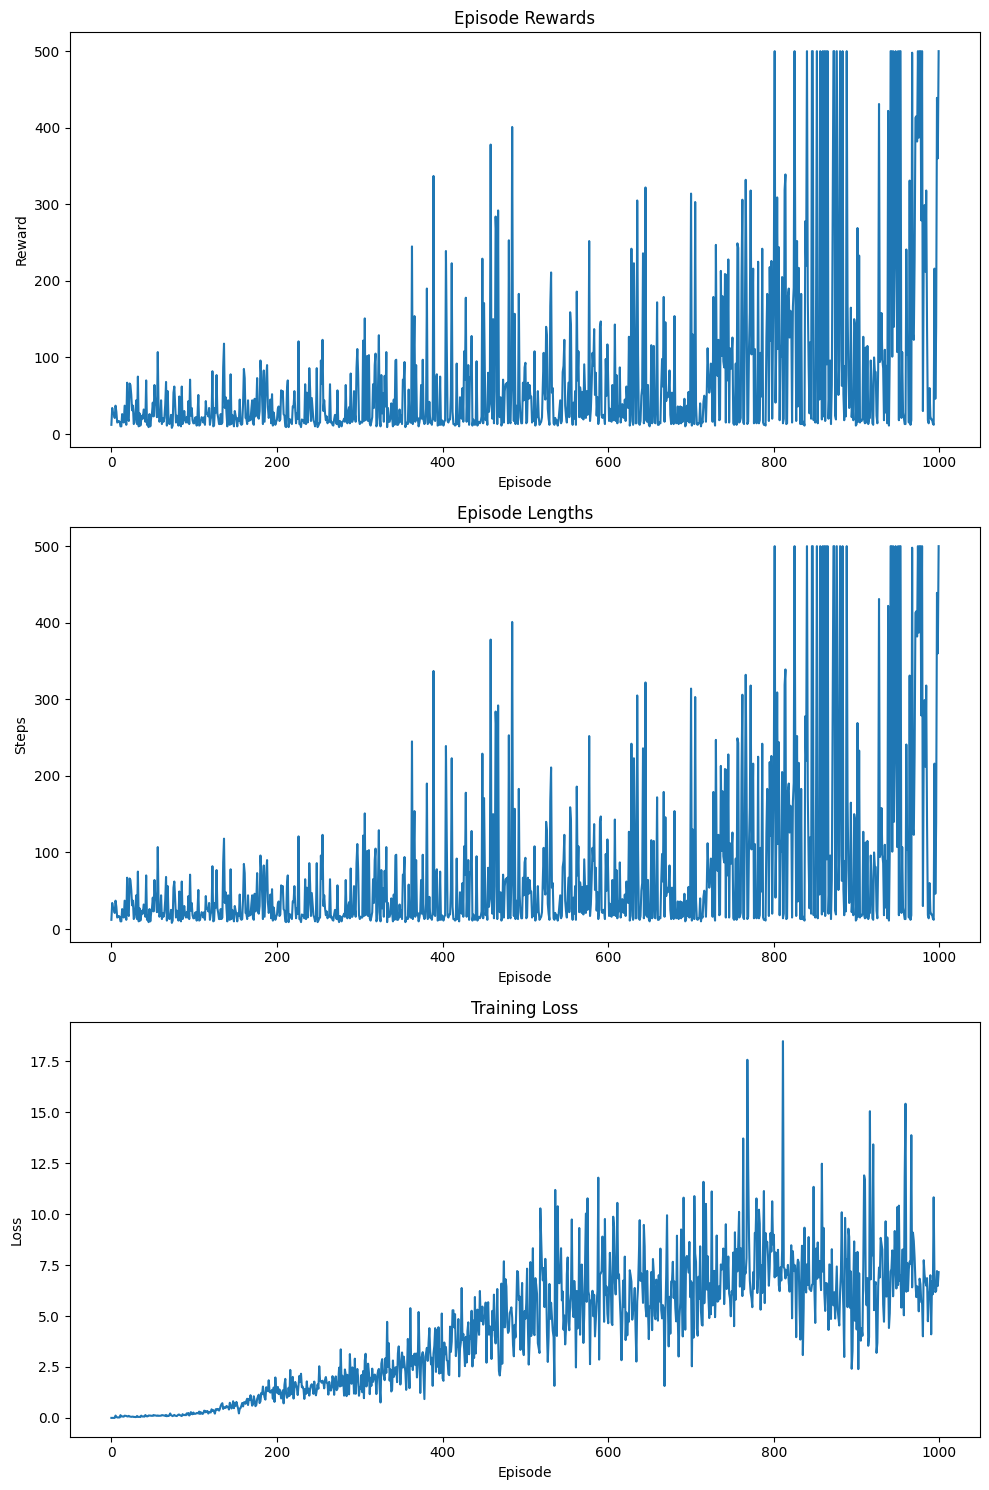

In [7]:
plot_training_results(rewards, lengths, losses)